# Série temporal - Bacia de Campos

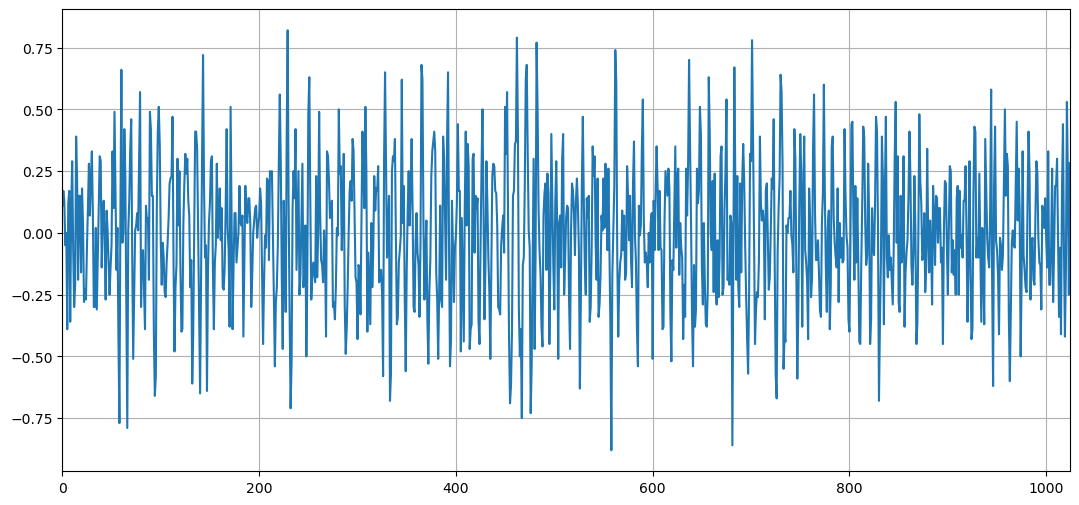

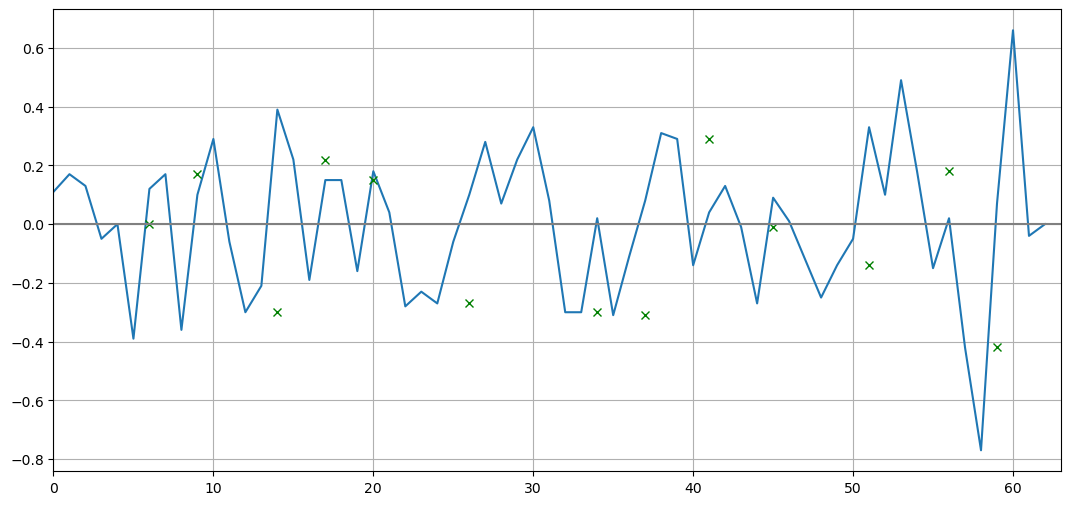

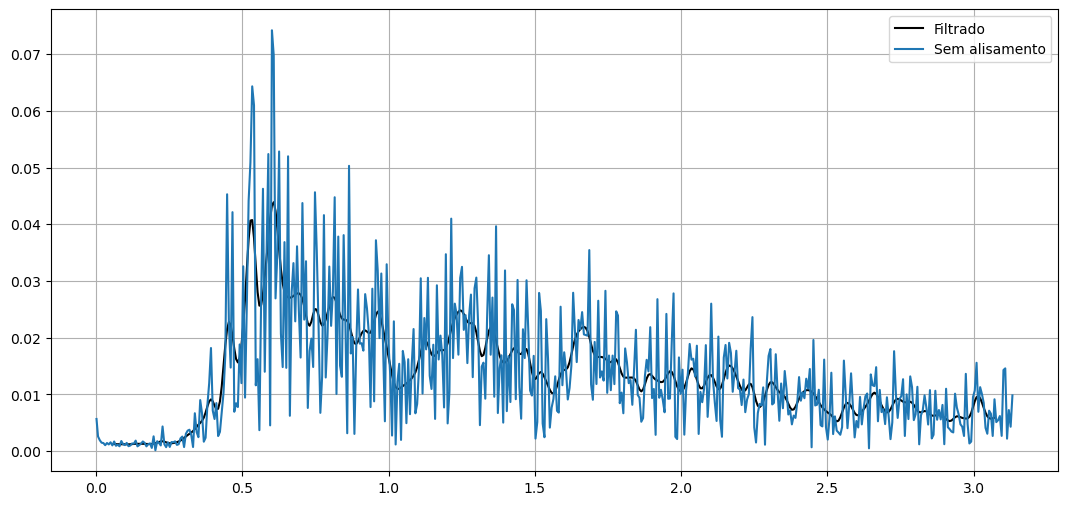

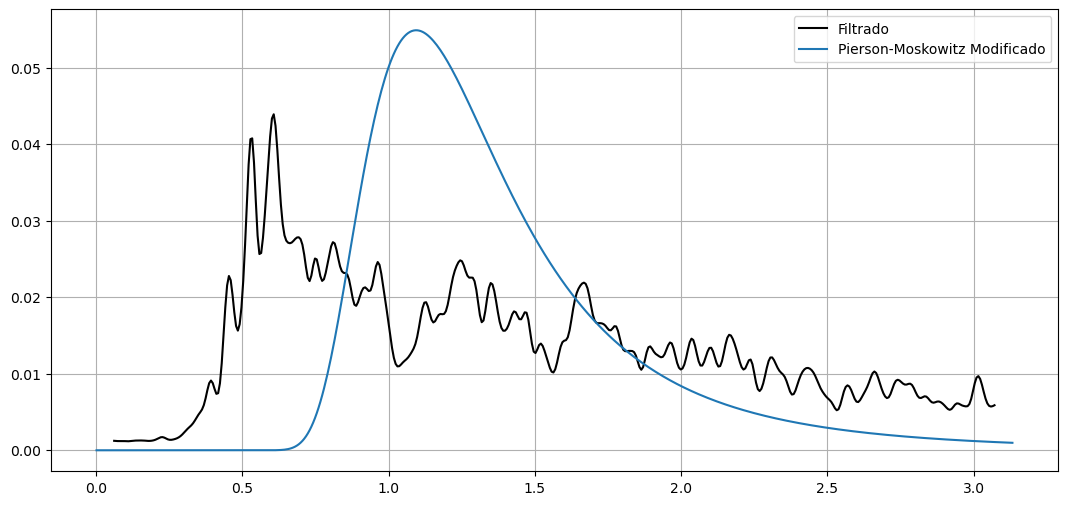

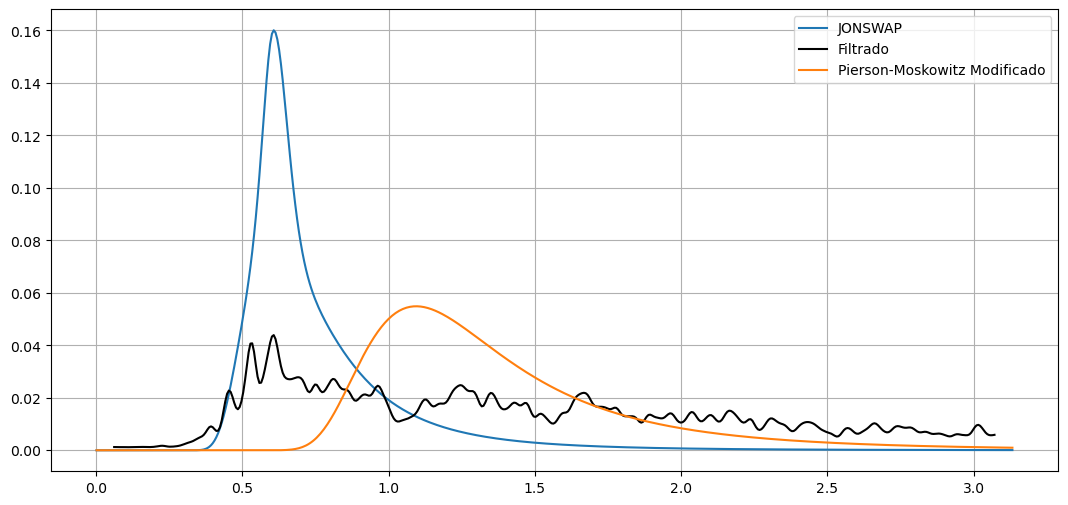

,Série temporal - 64 s,Espectro - FFT,Pierson-Moskowitz,JONSWAP
"$H_s$ , m",0.504762,0.818708,0.811136,0.817293
$\sigma$,0.133698,0.204677,0.202784,0.204323
"$T_1$ , s",3.470588,4.434663,4.601729,8.410580
"$T_z$ , s",4.416667,3.923538,4.392566,7.899064


In [42]:
import numpy as np
from matplotlib import pyplot as plt
import random
from scipy.signal import find_peaks, argrelextrema
from scipy import integrate
from scipy.fft import fft, fftfreq
import pandas as pd

df = pd.read_excel('ON111011.xlsx', header=None)
df = df.drop([0, 1])
t = np.arange(0, df.shape[0], 1)
plt.figure(figsize=(13,6))
plt.plot(t, df.iloc[:,0])
plt.xlim((0, t[-1]))
plt.grid()
plt.show()

T_c = 64 # Tempo de corte

# 1  - Média do sinal temporal
zeta_m = np.mean(df.iloc[:,0])

# 2 - Desvio padrão do sinal temporal
sig = np.std(df.iloc[:,0])

# 3 - Hs usando os primeiros 64 s da série temporal
S64 = df.iloc[0:T_c-1,0]
S64_ord = S64.sort_values(ascending=False).iloc[0:int(S64.shape[0]/3)]
Hs_64 = 2*np.mean(S64_ord)
sig_64 = np.std(S64_ord)
# 4 - Altura máxima por observação dos primeiros 64s da série temporal
Hmax_64 = 2*S64_ord.iloc[0]

# 5 - O período de zero ascendente médio usando valor inteiro de períodos em um total de 64 s
peaks, _ = find_peaks(S64, None)
t_ind = []
for ind in range(S64.shape[0]): 
    if ind > 0:
        if S64.iloc[ind] > 0 and S64.iloc[ind-1] < 0:
            t_ind.append(ind)
            
plt.figure(figsize=(13,6))
plt.plot(t[0:T_c-1], S64)
plt.xlim((0, t[T_c-1]))
plt.grid()
plt.axhline(y=0, color='gray')
plt.show()
Tz_64 = np.mean([t[t_ind][i]-t[t_ind][i-1] for i in range(len(t[t_ind])) if i > 0])

# 6 - O período entre cristas usando valor inteiro de períodos em um total de 64 s
T_64 = np.mean([t[peaks][i]-t[peaks][i-1] for i in range(len(t[peaks])) if i > 0])

# 7 e 8 - Espectro usando FFT + Alisamento usando janela de Hanning
s = fft(df.iloc[:,0])
N = df.shape[0]
dw = 1/(2*np.pi)
w = fftfreq(N, dw)[:N//2]
if w[0] == 0.0:
   w[0] = 0.001
S = 2.0/N * np.abs(s[0:N//2])
m = 10
s = S.copy()
W = w.copy()

for n in range(0, m):
    S_n = np.array(
        [0.5*s[i] + 0.25*(s[i-1] + s[i+1]) for i in range(1, len(s)-1)]
    )
    s = S_n
    w_n = W[1:len(W)-1]
    W = w_n

plt.figure(figsize=(13,6))
plt.plot(w_n, S_n, color='k', label='Filtrado')
plt.plot(w, S, label='Sem alisamento')
plt.grid()
plt.legend()
plt.show()

# 9 - Média usando resultado de 7
S_m = np.sqrt(np.mean(S))

# 10 - Desvio padrão usando resultado de 7
sig_spc = np.sqrt(integrate.simpson(S, w))

# 11 - Hs usando usando resultado de 7
Hs_spc = 4*sig_spc

# 12 - Altura máxima usando resultado de 7
Hmax_spc = 1.86*Hs_spc

# 13 - Período médio T1
T1_spc = 2*np.pi*(integrate.simpson(S, w)/integrate.simpson(S*w, w))

# 14 - Período médio T2
T2_spc = 2*np.pi*np.sqrt((integrate.simpson(S, w)/integrate.simpson(S*w**2, w)))

# 15 - Período de pico de 8 
Tp_spec = 2*np.pi/w_n[np.where(S_n==S_n.max())][0]

# 16 - Estimativa de largura espectral usando resultado de 7
T4_spec = 2*np.pi*np.sqrt((integrate.simpson(S*w**2, w)/integrate.simpson(S*w**4, w)))
ep = np.sqrt(1-(T4_spec/T2_spc)**2) 

# 17 - Comparar resultado de 7 com espectro PM modificado (ITTC) com resultados de 11 e 13
S_pm = ((173*Hs_spc**2)/(T1_spc**4))*(w**(-5))*np.exp(-(692/(T1_spc**4))*w**(-4))
plt.figure(figsize=(13,6))
plt.plot(w_n, S_n, color='k', label='Filtrado')
plt.plot(w, S_pm, label='Pierson-Moskowitz Modificado')
plt.grid()
plt.legend()
plt.show()

# 18 - Obter período de pico através do espectro obtido em 17
Tp_pm = 2*np.pi/w_n[np.where(S_pm==S_pm.max())][0]

# 19 - Definir os parâmetros do espectro JONSWAPs à maneira do CENPES
gama = 6.4*Tp_spec**(-0.491)
Tz_j = Tp_spec*np.sqrt((5+gama)/(10.89+gama))


f = w/(2*np.pi)
Sj_f = np.zeros_like(f)
fp = 1/Tp_spec
for freq in f:
    ind = np.where(f == freq)
    if freq <= fp:
        sigma = 0.07
        s_f = ( (5/16) * (Hs_spc**2) * Tp_spec * ((fp/freq)**5) * (1-0.287*np.log(gama)) * 
               np.exp(-1.25*(freq/fp)**(-4))*gama**np.exp((-(freq-fp)**2)/(2*(sigma**2)*fp**2)))
    else:
        sigma = 0.09
        s_f = ( (5/16) * (Hs_spc**2) * Tp_spec * ((fp/freq)**5) * (1-0.287*np.log(gama)) * 
               np.exp(-1.25*(freq/fp)**(-4))*gama**np.exp((-(freq-fp)**2)/(2*(sigma**2)*fp**2)))
    Sj_f[ind] = s_f
Sj_w = Sj_f/(2*np.pi)

plt.figure(figsize=(13,6))
# plt.plot(w_n, S_n, color='k', label='Filtrado')
plt.plot(w, Sj_w, label='JONSWAP')
plt.plot(w_n, S_n, color='k', label='Filtrado')
plt.plot(w, S_pm, label='Pierson-Moskowitz Modificado')
plt.grid()
plt.legend()
plt.show()

# 20 - Tabelas comparativas
sig_PM = np.sqrt((integrate.simpson(S_pm, w)))
Hs_PM = 4*sig_PM
T1_PM = 2*np.pi*(integrate.simpson(S_pm, w)/integrate.simpson(S_pm*w, w))
T2_PM = 2*np.pi*np.sqrt((integrate.simpson(S_pm, w)/integrate.simpson(S_pm*w**2, w)))
sig_J = np.sqrt((integrate.simpson(Sj_w, w)))
Hs_J = 4*sig_J
T1_J = 2*np.pi*(integrate.simpson(Sj_w, w)/integrate.simpson(Sj_w*w, w))
T2_J = 2*np.pi*np.sqrt((integrate.simpson(Sj_w, w)/integrate.simpson(Sj_w*w**2, w)))
                  
dict = {"Série temporal - 64 s": [Hs_64, sig_64, T_64, Tz_64], 
        "Espectro - FFT":        [Hs_spc, sig_spc, T1_spc, T2_spc], 
        "Pierson-Moskowitz":     [Hs_PM, sig_PM, T1_PM, T2_PM], 
        "JONSWAP":               [Hs_J, sig_J, T1_J, T2_J]}

df = pd.DataFrame(data = dict, index = [r"$H_s$ , m", r"$\sigma$", r"$T_1$ , s", r"$T_z$ , s"])
df
